In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from scipy.linalg import sqrtm
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from tqdm.auto import tqdm
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.uniform import Uniform
from torch.distributions.transforms import SigmoidTransform, AffineTransform

# Part 1: Setup & Baselines

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

# scale inot 0 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()
])

full_test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_indices = range(0, 1000)
test_indices = range(1000, 2000)


train_dataset = Subset(full_test_dataset, train_indices)
test_dataset = Subset(full_test_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

def create_flat_tensor_from_loader(loader):
    all_data = []
    for data, _ in loader:
        all_data.append(data)
    flat_tensor = torch.cat(all_data, dim=0)
    return flat_tensor.view(len(loader.dataset), -1).to(device)

X_train = create_flat_tensor_from_loader(train_loader)
X_test = create_flat_tensor_from_loader(test_loader)

print(f"Shape of the flat training tensor: {X_train.shape}")
print(f"Shape of the flat testing tensor: {X_test.shape}")


Using device: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.32MB/s]


Shape of the flat training tensor: torch.Size([1000, 784])
Shape of the flat testing tensor: torch.Size([1000, 784])


In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        features = F.relu(self.fc1(x))
        output = self.fc2(features)
        return output, features

In [4]:
# train LeNet on the hole dataset not just the first 1000 smaples of test set.
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

X_test_flat = test_dataset.data.view(len(test_dataset), -1).float() / 255.0
X_test_flat_binarized = (X_test_flat > 0.5).float().to(device)

X_train_flat_binarized = train_dataset.data.view(len(train_dataset), -1).float()
X_train_flat_binarized = (X_train_flat_binarized > 0.5).float()

test_loader_le= DataLoader(test_dataset, batch_size=128, shuffle=False)
train_loader_le = DataLoader(train_dataset, batch_size=128, shuffle=True)


lenet_model = LeNet().to(device)
lenet_optimizer = torch.optim.Adam(lenet_model.parameters(), lr=1e-3)
epochs = 10

lenet_model.train()
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(tqdm(train_loader_le, desc=f"Epoch {epoch}/{epochs}")):
        data, target = data.to(device), target.to(device)
        lenet_optimizer.zero_grad()
        output, _ = lenet_model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        lenet_optimizer.step()

torch.save(lenet_model.state_dict(), "lenet_mnist.pth")

Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

In [5]:

lenet_model = LeNet().to(device)
lenet_model.load_state_dict(torch.load("lenet_mnist.pth"))
lenet_model.eval()

def get_features(data, batch_size=128):
    features_list = []
    if len(data.shape) == 2:
        data = data.reshape(-1, 1, 28, 28)

    dataset = TensorDataset(torch.tensor(data).to(device))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for (batch,) in loader:
            _, features = lenet_model(batch)
            features_list.append(features.cpu().numpy())
    return np.concatenate(features_list, axis=0)

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def polynomial_kernel(X, Y):
    d = X.shape[1]
    return (X @ Y.T / d + 1) ** 3

def calculate_kid(act1, act2):
    n1, n2 = act1.shape[0], act2.shape[0]
    K_11 = polynomial_kernel(act1, act1)
    K_22 = polynomial_kernel(act2, act2)
    K_12 = polynomial_kernel(act1, act2)

    mmd2 = (np.sum(K_11) - np.trace(K_11)) / (n1 * (n1 - 1)) + \
           (np.sum(K_22) - np.trace(K_22)) / (n2 * (n2 - 1)) - \
           2 * np.sum(K_12) / (n1 * n2)
    return mmd2

def get_labels_and_probs(data, batch_size=128):
    probs_list = []
    if len(data.shape) == 2:
        data = data.reshape(-1, 1, 28, 28)
    dataset = TensorDataset(torch.tensor(data).to(device))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for (batch,) in loader:
            output, _ = lenet_model(batch)
            probs = F.softmax(output, dim=1).cpu().numpy()
            probs_list.append(probs)
    return np.concatenate(probs_list, axis=0)

def calculate_is_and_diversity(probs):
    kl_divs = probs * (np.log(probs) - np.log(np.mean(probs, axis=0, keepdims=True)))
    kl_divs = np.sum(kl_divs, axis=1)
    is_score = np.exp(np.mean(kl_divs))

    # Diversity (Entropy of marginal label distribution)
    p_y = np.mean(probs, axis=0)
    diversity = -np.sum(p_y * np.log(p_y))

    # Sparsity (KL divergence from uniform distribution)
    uniform_dist = np.full(p_y.shape, 1.0 / len(p_y))
    sparsity = np.sum(p_y * np.log(p_y / uniform_dist))

    return is_score, diversity, sparsity

def plot_samples(samples, title, n_rows=1, n_cols=10):
    samples = samples.reshape(-1, 28, 28)
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for i in range(min(len(samples), n_rows * n_cols)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(samples[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()



In [ ]:
def plot_samples(samples, title, n_rows=1, n_cols=10):
    samples = samples.reshape(-1, 28, 28)
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for i in range(min(len(samples), n_rows * n_cols)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(samples[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

In [6]:
real_features = get_features(X_test.cpu().numpy())

# Part 2: Training

## Flow based model : NICE

In [7]:
seed = 101

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class NICE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=1024, num_coupling_layers=4):
        super(NICE, self).__init__()
        self.input_dim = input_dim
        self.num_coupling_layers = num_coupling_layers
        self.s = nn.Parameter(torch.randn(input_dim))

        self.coupling_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim // 2, hidden_dim), nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                nn.Linear(hidden_dim, input_dim // 2),
            ) for _ in range(num_coupling_layers)
        ])

    def forward(self, x):
        z = x
        for i, net in enumerate(self.coupling_layers):
            z1, z2 = z.chunk(2, dim=1)
            if i % 2 == 0:
                z2 = z2 + net(z1)
            else:
                z1 = z1 + net(z2)
            z = torch.cat([z1, z2], dim=1)
        z = z * torch.exp(self.s)
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z / torch.exp(self.s)
        for i, net in reversed(list(enumerate(self.coupling_layers))):
            x1, x2 = x.chunk(2, dim=1)
            if i % 2 == 0:
                x2 = x2 - net(x1)
            else:
                x1 = x1 - net(x2)
            x = torch.cat([x1, x2], dim=1)
        return x

    def sample(self, n):
        self.eval()
        samples = torch.zeros(n, 28, 28)

        with torch.no_grad():
            for i in range(n):
                z = torch.randn(1, self.input_dim).to(device)
                x_gen = self.invert(z)
                samples[i] = x_gen.view(28, 28).cpu().clamp(0, 1)

        return samples

def train_nice_with_monitoring(model, optimizer, train_loader, test_loader, epochs, eval_freq=5, train_losses=[], test_losses=[]):
    history = []
    model = model.to(device)
    start_time = time.time()

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for data, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
            x = data.view(data.size(0), -1).to(device)

            z, log_jacobian = model(x)

            log_prob = -0.5 * (z ** 2 + torch.log(torch.tensor(2 * torch.pi))).sum(dim=1)
            loss = -(log_prob + log_jacobian).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            test_loss = 0
            for x_batch, _ in test_loader:
                x_batch = x_batch.view(x_batch.size(0), -1).to(device)
                z, log_jacobian = model(x_batch)
                log_prob = -0.5 * (z ** 2 + torch.log(torch.tensor(2 * torch.pi))).sum(dim=1)
                nll = -(log_prob + log_jacobian).mean()
                test_loss += nll.item()

            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)

        print(f"Epoch {epoch}, training_loss = {avg_train_loss:.4f}, test_loss = {avg_test_loss:.4f}")

    return pd.DataFrame(history)


nice_monitored = NICE().to(device)
nice_optimizer_monitored = optim.Adam(nice_monitored.parameters(), lr=1e-4)

train_losses = []
test_losses = []

start_time = time.time()
nice_history = train_nice_with_monitoring(
    nice_monitored,
    nice_optimizer_monitored,
    train_loader,
    test_loader,
    epochs=100,
    train_losses = train_losses,
    test_losses = test_losses
)
end_time = time.time()


torch.save(nice_monitored.state_dict(), "nice_mnist.pth")

Epoch 1, training_loss = 1073.7260, test_loss = 1024.0009


Epoch 2, training_loss = 1007.9892, test_loss = 981.9815


Epoch 3, training_loss = 975.8111, test_loss = 970.3008


Epoch 4, training_loss = 963.3536, test_loss = 959.6740


Epoch 5, training_loss = 954.5976, test_loss = 953.9820


Epoch 6, training_loss = 946.1878, test_loss = 947.0673


Epoch 7, training_loss = 937.3804, test_loss = 940.6990


Epoch 8, training_loss = 928.5917, test_loss = 933.8190


Epoch 9, training_loss = 918.7705, test_loss = 925.6130


Epoch 10, training_loss = 907.1248, test_loss = 917.2793


Epoch 11, training_loss = 895.7583, test_loss = 906.1569


Epoch 12, training_loss = 885.5242, test_loss = 898.8069


Epoch 13, training_loss = 876.1689, test_loss = 890.1719


Epoch 14, training_loss = 867.7971, test_loss = 884.9247


Epoch 15, training_loss = 861.4932, test_loss = 880.0973


Epoch 16, training_loss = 854.4945, test_loss = 877.0450


Epoch 17, training_loss = 847.8304, test_loss = 871.1630


Epoch 18, training_loss = 841.0664, test_loss = 867.5054


Epoch 19, training_loss = 835.6523, test_loss = 862.7234


Epoch 20, training_loss = 829.6743, test_loss = 859.5986


Epoch 21, training_loss = 825.3693, test_loss = 855.5142


Epoch 22, training_loss = 820.7245, test_loss = 853.3085


Epoch 23, training_loss = 816.3328, test_loss = 852.5517


Epoch 24, training_loss = 813.3346, test_loss = 850.5623


Epoch 25, training_loss = 809.6862, test_loss = 845.8087


Epoch 26, training_loss = 805.8795, test_loss = 843.4013


Epoch 27, training_loss = 802.1831, test_loss = 841.0015


Epoch 28, training_loss = 799.0043, test_loss = 840.2042


Epoch 29, training_loss = 796.6606, test_loss = 837.5634


Epoch 30, training_loss = 794.0572, test_loss = 836.5147


Epoch 31, training_loss = 791.5259, test_loss = 835.6591


Epoch 32, training_loss = 788.5881, test_loss = 832.1269


Epoch 33, training_loss = 785.8785, test_loss = 829.1630


Epoch 34, training_loss = 783.5522, test_loss = 828.6140


Epoch 35, training_loss = 781.2444, test_loss = 826.2244


Epoch 36, training_loss = 778.9276, test_loss = 826.2910


Epoch 37, training_loss = 776.7360, test_loss = 825.0146


Epoch 38, training_loss = 774.3800, test_loss = 823.2465


Epoch 39, training_loss = 772.2618, test_loss = 822.4140


Epoch 40, training_loss = 770.5576, test_loss = 820.3485


Epoch 41, training_loss = 769.2398, test_loss = 820.4461


Epoch 42, training_loss = 767.3699, test_loss = 818.4924


Epoch 43, training_loss = 765.2879, test_loss = 818.6141


Epoch 44, training_loss = 763.6369, test_loss = 815.9031


Epoch 45, training_loss = 761.9449, test_loss = 817.8336


Epoch 46, training_loss = 760.3324, test_loss = 814.2775


Epoch 47, training_loss = 759.7314, test_loss = 815.7124


Epoch 48, training_loss = 757.4605, test_loss = 812.5162


Epoch 49, training_loss = 755.8532, test_loss = 812.3752


Epoch 50, training_loss = 754.5719, test_loss = 813.1295


Epoch 51, training_loss = 753.1162, test_loss = 809.9218


Epoch 52, training_loss = 751.4994, test_loss = 809.0533


Epoch 53, training_loss = 750.0655, test_loss = 808.7828


Epoch 54, training_loss = 748.7353, test_loss = 807.8783


Epoch 55, training_loss = 747.1097, test_loss = 806.6548


Epoch 56, training_loss = 745.8422, test_loss = 806.5650


Epoch 57, training_loss = 744.5307, test_loss = 806.0339


Epoch 58, training_loss = 744.5393, test_loss = 806.4526


Epoch 59, training_loss = 743.2783, test_loss = 804.1285


Epoch 60, training_loss = 741.5001, test_loss = 801.9792


Epoch 61, training_loss = 739.8480, test_loss = 802.0141


Epoch 62, training_loss = 738.7481, test_loss = 801.1622


Epoch 63, training_loss = 738.0150, test_loss = 801.1468


Epoch 64, training_loss = 736.6663, test_loss = 800.0816


Epoch 65, training_loss = 735.1241, test_loss = 798.5303


Epoch 66, training_loss = 733.6973, test_loss = 798.4974


Epoch 67, training_loss = 732.7046, test_loss = 798.0100


Epoch 68, training_loss = 731.7990, test_loss = 797.9569


Epoch 69, training_loss = 731.1628, test_loss = 797.5848


Epoch 70, training_loss = 730.0588, test_loss = 796.6663


Epoch 71, training_loss = 729.5043, test_loss = 796.3801


Epoch 72, training_loss = 728.1835, test_loss = 795.2344


Epoch 73, training_loss = 726.8816, test_loss = 793.2702


Epoch 74, training_loss = 725.5010, test_loss = 792.5091


Epoch 75, training_loss = 724.5487, test_loss = 792.7446


Epoch 76, training_loss = 723.5018, test_loss = 792.9717


Epoch 77, training_loss = 722.7151, test_loss = 791.3192


Epoch 78, training_loss = 721.7767, test_loss = 791.7127


Epoch 79, training_loss = 720.6971, test_loss = 789.8337


Epoch 80, training_loss = 719.6427, test_loss = 790.1065


Epoch 81, training_loss = 718.5157, test_loss = 788.9926


Epoch 82, training_loss = 717.4533, test_loss = 788.0085


Epoch 83, training_loss = 716.4469, test_loss = 787.4394


Epoch 84, training_loss = 716.3093, test_loss = 787.7803


Epoch 85, training_loss = 715.4507, test_loss = 785.3366


Epoch 86, training_loss = 713.9152, test_loss = 784.8541


Epoch 87, training_loss = 712.8636, test_loss = 785.8017


Epoch 88, training_loss = 711.8940, test_loss = 784.1892


Epoch 89, training_loss = 710.8309, test_loss = 783.9910


Epoch 90, training_loss = 709.9900, test_loss = 783.9606


Epoch 91, training_loss = 709.5613, test_loss = 783.8544


Epoch 92, training_loss = 709.0909, test_loss = 782.8575


Epoch 93, training_loss = 707.9139, test_loss = 781.7428


Epoch 94, training_loss = 706.8594, test_loss = 782.1441


Epoch 95, training_loss = 705.9329, test_loss = 780.0143


Epoch 96, training_loss = 704.9661, test_loss = 779.3610


Epoch 97, training_loss = 704.1237, test_loss = 779.9497


Epoch 98, training_loss = 703.1962, test_loss = 779.9566


Epoch 99, training_loss = 702.8553, test_loss = 778.5029


Epoch 100, training_loss = 701.8211, test_loss = 779.5079


In [9]:
nice_training_time = end_time - start_time
print(f"NICE Training time = {nice_training_time}")

NICE Training time = 50.50878858566284


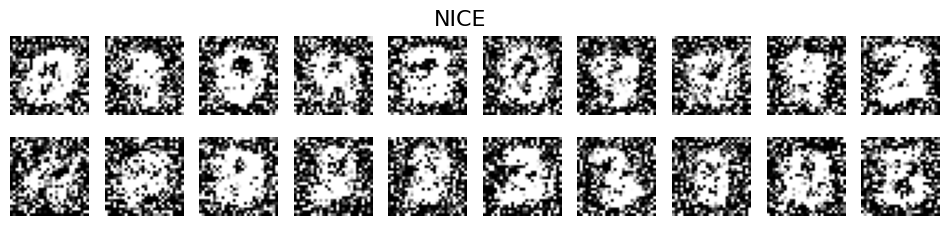

In [10]:
samples = nice_monitored.sample(1000)

plot_samples(samples.detach().cpu().numpy(), "NICE")

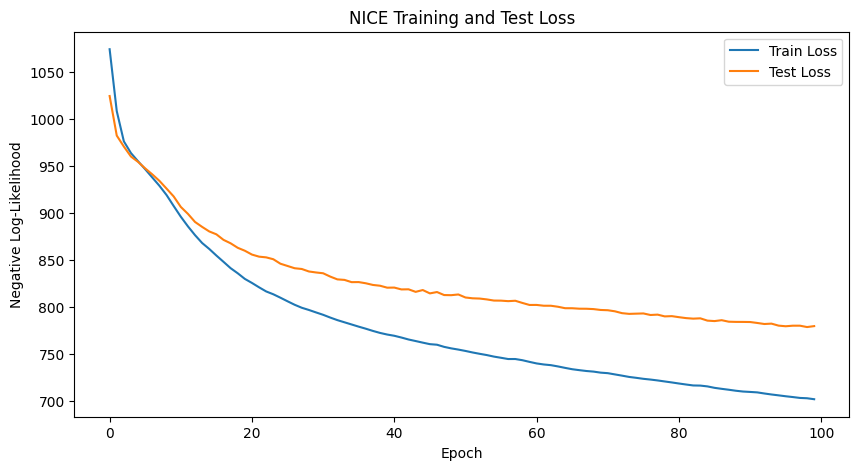

In [11]:
plt.figure(figsize=(10, 5))
plt.title("NICE Training and Test Loss")
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.legend()
plt.show()

## GAN

In [152]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=784):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            # nn.Linear(512, 1024),
            # nn.LeakyReLU(0.2),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.gen(z).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self, img_dim=784, dropout_p=0.2):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.disc(x)


z_dim = 100
epochs = 100

G_losses = []
D_losses = []

generator = Generator(z_dim = z_dim).to(device)
discriminator = Discriminator().to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr=2e-4)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)
criterion = nn.BCELoss()


start_time = time.time()
for epoch in range(1, epochs+1):
    generator.train()
    discriminator.train()
    g_loss_epoch, d_loss_epoch = 0, 0

    for real_imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.view(batch_size, -1).to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        disc_optimizer.zero_grad()
        real_preds = discriminator(real_imgs)
        real_loss = criterion(real_preds, real_labels)

        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = criterion(fake_preds, fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        disc_optimizer.step()
        d_loss_epoch += d_loss.item()

        # Train Generator
        gen_optimizer.zero_grad()
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)
        fake_preds = discriminator(fake_imgs)
        g_loss = criterion(fake_preds, real_labels)
        g_loss.backward()
        gen_optimizer.step()
        g_loss_epoch += g_loss.item()
    avg_g_loss = g_loss_epoch / len(train_loader)
    avg_d_loss = d_loss_epoch / len(train_loader)
    G_losses.append(avg_g_loss)
    D_losses.append(avg_d_loss)
    print(f"Epoch {epoch}, Generator Loss: {avg_g_loss:.4f}, Discriminator Loss: {avg_d_loss:.4f}")

end_time = time.time()

total_time = time.time() - start_time
print(f"Total GAN training time: {total_time:.2f} seconds")

torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")


Epoch 1, Generator Loss: 0.6738, Discriminator Loss: 1.3699


Epoch 2, Generator Loss: 0.6392, Discriminator Loss: 1.3373


Epoch 3, Generator Loss: 0.5880, Discriminator Loss: 1.3386


Epoch 4, Generator Loss: 0.5849, Discriminator Loss: 1.3395


Epoch 5, Generator Loss: 0.6818, Discriminator Loss: 1.2807


Epoch 6, Generator Loss: 0.8444, Discriminator Loss: 1.2412


Epoch 7, Generator Loss: 1.0171, Discriminator Loss: 1.3018


Epoch 8, Generator Loss: 1.1785, Discriminator Loss: 1.3936


Epoch 9, Generator Loss: 1.2519, Discriminator Loss: 1.4071


Epoch 10, Generator Loss: 1.2009, Discriminator Loss: 1.3065


Epoch 11, Generator Loss: 1.0204, Discriminator Loss: 1.2047


Epoch 12, Generator Loss: 0.9236, Discriminator Loss: 1.0813


Epoch 13, Generator Loss: 0.9736, Discriminator Loss: 0.9159


Epoch 14, Generator Loss: 1.1483, Discriminator Loss: 0.7716


Epoch 15, Generator Loss: 1.5629, Discriminator Loss: 0.5899


Epoch 16, Generator Loss: 2.1160, Discriminator Loss: 0.4588


Epoch 17, Generator Loss: 2.3588, Discriminator Loss: 0.4887


Epoch 18, Generator Loss: 2.2202, Discriminator Loss: 0.6854


Epoch 19, Generator Loss: 1.7580, Discriminator Loss: 1.0529


Epoch 20, Generator Loss: 1.6034, Discriminator Loss: 1.1620


Epoch 21, Generator Loss: 2.4406, Discriminator Loss: 0.5981


Epoch 22, Generator Loss: 3.5419, Discriminator Loss: 0.2275


Epoch 23, Generator Loss: 2.9690, Discriminator Loss: 0.2656


Epoch 24, Generator Loss: 3.6677, Discriminator Loss: 0.2461


Epoch 25, Generator Loss: 3.6772, Discriminator Loss: 0.3653


Epoch 26, Generator Loss: 3.1327, Discriminator Loss: 0.7290


Epoch 27, Generator Loss: 3.1048, Discriminator Loss: 0.9246


Epoch 28, Generator Loss: 3.3499, Discriminator Loss: 0.6172


Epoch 29, Generator Loss: 3.4469, Discriminator Loss: 0.5545


Epoch 30, Generator Loss: 3.1332, Discriminator Loss: 0.5430


Epoch 31, Generator Loss: 3.6260, Discriminator Loss: 0.5785


Epoch 32, Generator Loss: 3.6949, Discriminator Loss: 0.5831


Epoch 33, Generator Loss: 3.5846, Discriminator Loss: 0.5713


Epoch 34, Generator Loss: 3.1856, Discriminator Loss: 0.9243


Epoch 35, Generator Loss: 2.4797, Discriminator Loss: 1.4926


Epoch 36, Generator Loss: 2.3688, Discriminator Loss: 1.2823


Epoch 37, Generator Loss: 2.2100, Discriminator Loss: 1.2398


Epoch 38, Generator Loss: 1.5422, Discriminator Loss: 1.6253


Epoch 39, Generator Loss: 1.1640, Discriminator Loss: 1.9905


Epoch 40, Generator Loss: 1.2556, Discriminator Loss: 1.6063


Epoch 41, Generator Loss: 1.9949, Discriminator Loss: 0.6722


Epoch 42, Generator Loss: 1.8664, Discriminator Loss: 0.4759


Epoch 43, Generator Loss: 1.5465, Discriminator Loss: 0.6660


Epoch 44, Generator Loss: 1.3978, Discriminator Loss: 1.0503


Epoch 45, Generator Loss: 1.1844, Discriminator Loss: 1.3442


Epoch 46, Generator Loss: 1.2601, Discriminator Loss: 1.0243


Epoch 47, Generator Loss: 1.1269, Discriminator Loss: 1.1552


Epoch 48, Generator Loss: 1.0220, Discriminator Loss: 1.4437


Epoch 49, Generator Loss: 1.3658, Discriminator Loss: 1.1466


Epoch 50, Generator Loss: 2.4943, Discriminator Loss: 0.4918


Epoch 51, Generator Loss: 2.2208, Discriminator Loss: 0.4509


Epoch 52, Generator Loss: 2.0115, Discriminator Loss: 0.5992


Epoch 53, Generator Loss: 2.1688, Discriminator Loss: 0.7613


Epoch 54, Generator Loss: 1.4852, Discriminator Loss: 1.4445


Epoch 55, Generator Loss: 1.3716, Discriminator Loss: 1.4647


Epoch 56, Generator Loss: 1.5416, Discriminator Loss: 0.9747


Epoch 57, Generator Loss: 1.5855, Discriminator Loss: 0.9021


Epoch 58, Generator Loss: 1.4614, Discriminator Loss: 1.1893


Epoch 59, Generator Loss: 1.3683, Discriminator Loss: 1.3236


Epoch 60, Generator Loss: 1.5356, Discriminator Loss: 1.0474


Epoch 61, Generator Loss: 1.7965, Discriminator Loss: 0.7035


Epoch 62, Generator Loss: 1.9070, Discriminator Loss: 0.6054


Epoch 63, Generator Loss: 1.6309, Discriminator Loss: 0.7870


Epoch 64, Generator Loss: 1.1168, Discriminator Loss: 1.3061


Epoch 65, Generator Loss: 1.0117, Discriminator Loss: 1.5520


Epoch 66, Generator Loss: 1.3392, Discriminator Loss: 0.9574


Epoch 67, Generator Loss: 1.4841, Discriminator Loss: 0.7574


Epoch 68, Generator Loss: 1.0924, Discriminator Loss: 1.1858


Epoch 69, Generator Loss: 0.6519, Discriminator Loss: 2.0473


Epoch 70, Generator Loss: 0.7918, Discriminator Loss: 1.9270


Epoch 71, Generator Loss: 1.4936, Discriminator Loss: 0.9233


Epoch 72, Generator Loss: 1.4479, Discriminator Loss: 0.7963


Epoch 73, Generator Loss: 0.9613, Discriminator Loss: 1.4415


Epoch 74, Generator Loss: 0.5362, Discriminator Loss: 2.3139


Epoch 75, Generator Loss: 0.6284, Discriminator Loss: 1.9196


Epoch 76, Generator Loss: 1.1107, Discriminator Loss: 1.1179


Epoch 77, Generator Loss: 1.4204, Discriminator Loss: 0.7489


Epoch 78, Generator Loss: 1.4042, Discriminator Loss: 0.6928


Epoch 79, Generator Loss: 1.2645, Discriminator Loss: 0.8586


Epoch 80, Generator Loss: 0.8567, Discriminator Loss: 1.3705


Epoch 81, Generator Loss: 0.5315, Discriminator Loss: 1.9434


Epoch 82, Generator Loss: 0.5315, Discriminator Loss: 1.9556


Epoch 83, Generator Loss: 0.6741, Discriminator Loss: 1.5956


Epoch 84, Generator Loss: 0.7898, Discriminator Loss: 1.3430


Epoch 85, Generator Loss: 0.8057, Discriminator Loss: 1.2677


Epoch 86, Generator Loss: 0.8316, Discriminator Loss: 1.1996


Epoch 87, Generator Loss: 0.9074, Discriminator Loss: 1.1286


Epoch 88, Generator Loss: 1.0210, Discriminator Loss: 1.0223


Epoch 89, Generator Loss: 1.0672, Discriminator Loss: 0.9884


Epoch 90, Generator Loss: 0.9660, Discriminator Loss: 1.1028


Epoch 91, Generator Loss: 0.7424, Discriminator Loss: 1.4189


Epoch 92, Generator Loss: 0.4958, Discriminator Loss: 1.8802


Epoch 93, Generator Loss: 0.3694, Discriminator Loss: 2.1332


Epoch 94, Generator Loss: 0.3683, Discriminator Loss: 1.8656


Epoch 95, Generator Loss: 0.5075, Discriminator Loss: 1.4927


Epoch 96, Generator Loss: 0.7380, Discriminator Loss: 1.2006


Epoch 97, Generator Loss: 0.9223, Discriminator Loss: 1.0349


Epoch 98, Generator Loss: 1.0114, Discriminator Loss: 0.9232


Epoch 99, Generator Loss: 1.0654, Discriminator Loss: 0.8730


Epoch 100, Generator Loss: 1.0579, Discriminator Loss: 0.9101
Total GAN training time: 18.58 seconds


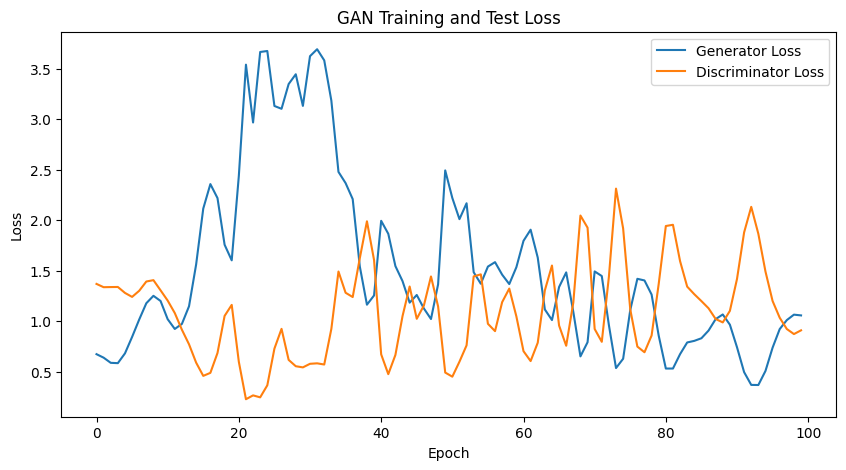

In [153]:
plt.figure(figsize=(10, 5))
plt.title("GAN Training and Test Loss")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [150]:
def generate_gan_samples(generator, n_samples, z_dim=100):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, z_dim, device=device)
        fake_imgs = generator(z)
    return fake_imgs.detach().cpu().numpy()

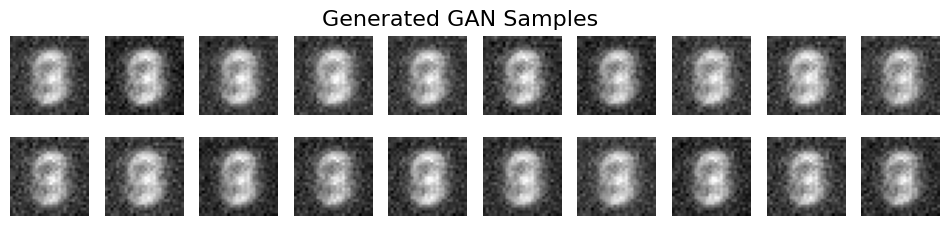

In [154]:
samples = generate_gan_samples(generator, n_samples=1000, z_dim=100)
plot_samples(samples, title="Generated GAN Samples")

## EBM

In [42]:
class EBM(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, n_hidden_layers=2):
        super(EBM, self).__init__()

        layers = [nn.Linear(input_dim, hidden_dim * 2), nn.LeakyReLU(0.2)]
        for _ in range(n_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim * 2, hidden_dim))
            layers.append(nn.LeakyReLU(0.2))
        layers.append(nn.Linear(hidden_dim, 1))

        self.energy_fn = nn.Sequential(*layers)

    def forward(self, x):
        return self.energy_fn(x).squeeze()

In [43]:
def sgld_sample(model, x_init, steps=60, step_size=10.0, noise_scale=0.005, constrain=False):
    x = x_init.clone().detach().to(x_init.device)
    x.requires_grad_(True)

    for _ in range(steps):
        energy = model(x).sum()
        grad = torch.autograd.grad(energy, x, retain_graph=False, create_graph=False)[0]

        # Langevin update
        x = x - 0.5 * step_size * grad
        x = x + noise_scale * torch.randn_like(x)

        if constrain:
            x = torch.clamp(x, 0.0, 1.0)

        x = x.detach().requires_grad_(True)

    return x.detach()


In [48]:
image_size=784
hidden_dim=256
num_epochs=100
mcmc_steps=60
mcmc_lr=10.0

ebm = EBM().to(device)
optimizer = optim.Adam(ebm.parameters(), lr=1e-4)

train_losses = []
test_losses = []
epoch_history = []
time_history = []

replay_buffer_size = 10000
replay_buffer = torch.rand(replay_buffer_size, image_size, device=device)

start_time = time.time()

for epoch in range(num_epochs):
    ebm.train()
    epoch_train_loss = 0

    for real_images, _ in tqdm(train_loader, leave=False):
        real_images = real_images.view(real_images.size(0), -1).to(device)

        batch_size = real_images.size(0)
        num_uniform = int(0.05 * batch_size)
        num_buffer = batch_size - num_uniform

        uniform_samples = torch.rand(num_uniform, image_size, device=device)

        buffer_indices = torch.randint(0, replay_buffer_size, (num_buffer,))
        buffer_samples = replay_buffer[buffer_indices]

        mcmc_samples_init = torch.cat([uniform_samples, buffer_samples], dim=0)
        mcmc_samples = sgld_sample(ebm, mcmc_samples_init, steps=mcmc_steps, step_size=mcmc_lr, constrain=True)

        # Update replay buffer
        replay_buffer[buffer_indices] = mcmc_samples[num_uniform:].detach()


        # Calculate loss
        real_energy = ebm(real_images).mean()
        fake_energy = ebm(mcmc_samples.detach()).mean()
        loss = real_energy - fake_energy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    ebm.eval()
    with torch.no_grad():
        test_loss = 0
        for test_images, _ in test_loader:
            test_images = test_images.view(test_images.size(0), -1).to(device)
            test_energy = ebm(test_images).mean()
            test_loss += test_energy.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

    epoch_history.append(epoch + 1)
    time_history.append(time.time() - start_time)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

end_time = time.time()
total_time = end_time - start_time

torch.save(ebm.state_dict(), "ebm_mnist_new.pth")

Epoch 1/100, Train Loss: 0.5009, Test Loss: -0.0095


Epoch 2/100, Train Loss: 0.0485, Test Loss: -0.0362


Epoch 3/100, Train Loss: 0.0112, Test Loss: -0.0643


Epoch 4/100, Train Loss: 0.0226, Test Loss: -0.0508


Epoch 5/100, Train Loss: 0.0223, Test Loss: -0.0500


Epoch 6/100, Train Loss: 0.0234, Test Loss: -0.0630


Epoch 7/100, Train Loss: 0.0180, Test Loss: -0.0840


Epoch 8/100, Train Loss: 0.0090, Test Loss: -0.1042


Epoch 9/100, Train Loss: 0.0061, Test Loss: -0.1271


Epoch 10/100, Train Loss: 0.0077, Test Loss: -0.1284


Epoch 11/100, Train Loss: 0.0018, Test Loss: -0.1467


Epoch 12/100, Train Loss: 0.0018, Test Loss: -0.1610


Epoch 13/100, Train Loss: 0.0088, Test Loss: -0.1597


Epoch 14/100, Train Loss: 0.0015, Test Loss: -0.1782


Epoch 15/100, Train Loss: 0.0105, Test Loss: -0.1837


Epoch 16/100, Train Loss: 0.0080, Test Loss: -0.1781


Epoch 17/100, Train Loss: 0.0023, Test Loss: -0.1958


Epoch 18/100, Train Loss: 0.0163, Test Loss: -0.1763


Epoch 19/100, Train Loss: 0.0031, Test Loss: -0.1926


Epoch 20/100, Train Loss: 0.0084, Test Loss: -0.1911


Epoch 21/100, Train Loss: 0.0038, Test Loss: -0.1906


Epoch 22/100, Train Loss: 0.0082, Test Loss: -0.2010


Epoch 23/100, Train Loss: 0.0051, Test Loss: -0.1842


Epoch 24/100, Train Loss: 0.0064, Test Loss: -0.1907


Epoch 25/100, Train Loss: 0.0081, Test Loss: -0.1996


Epoch 26/100, Train Loss: 0.0063, Test Loss: -0.1947


Epoch 27/100, Train Loss: 0.0071, Test Loss: -0.1912


Epoch 28/100, Train Loss: 0.0049, Test Loss: -0.1933


Epoch 29/100, Train Loss: 0.0072, Test Loss: -0.2014


Epoch 30/100, Train Loss: 0.0029, Test Loss: -0.1933


Epoch 31/100, Train Loss: 0.0054, Test Loss: -0.1881


Epoch 32/100, Train Loss: 0.0064, Test Loss: -0.2011


Epoch 33/100, Train Loss: 0.0063, Test Loss: -0.1842


Epoch 34/100, Train Loss: 0.0088, Test Loss: -0.1847


Epoch 35/100, Train Loss: 0.0086, Test Loss: -0.2020


Epoch 36/100, Train Loss: 0.0056, Test Loss: -0.1891


Epoch 37/100, Train Loss: 0.0082, Test Loss: -0.1839


Epoch 38/100, Train Loss: 0.0051, Test Loss: -0.1902


Epoch 39/100, Train Loss: 0.0087, Test Loss: -0.1896


Epoch 40/100, Train Loss: 0.0070, Test Loss: -0.1695


Epoch 41/100, Train Loss: 0.0079, Test Loss: -0.1873


Epoch 42/100, Train Loss: 0.0065, Test Loss: -0.1850


Epoch 43/100, Train Loss: 0.0066, Test Loss: -0.1766


Epoch 44/100, Train Loss: 0.0076, Test Loss: -0.1785


Epoch 45/100, Train Loss: 0.0059, Test Loss: -0.1722


Epoch 46/100, Train Loss: 0.0074, Test Loss: -0.1736


Epoch 47/100, Train Loss: 0.0060, Test Loss: -0.1721


Epoch 48/100, Train Loss: 0.0059, Test Loss: -0.1742


Epoch 49/100, Train Loss: 0.0038, Test Loss: -0.1734


Epoch 50/100, Train Loss: 0.0064, Test Loss: -0.1839


Epoch 51/100, Train Loss: 0.0075, Test Loss: -0.1602


Epoch 52/100, Train Loss: 0.0053, Test Loss: -0.1680


Epoch 53/100, Train Loss: 0.0048, Test Loss: -0.1558


Epoch 54/100, Train Loss: 0.0057, Test Loss: -0.1737


Epoch 55/100, Train Loss: 0.0052, Test Loss: -0.1600


Epoch 56/100, Train Loss: 0.0054, Test Loss: -0.1659


Epoch 57/100, Train Loss: 0.0040, Test Loss: -0.1540


Epoch 58/100, Train Loss: 0.0032, Test Loss: -0.1546


Epoch 59/100, Train Loss: 0.0049, Test Loss: -0.1606


Epoch 60/100, Train Loss: 0.0013, Test Loss: -0.1530


Epoch 61/100, Train Loss: 0.0032, Test Loss: -0.1719


Epoch 62/100, Train Loss: 0.0030, Test Loss: -0.1636


Epoch 63/100, Train Loss: 0.0037, Test Loss: -0.1466


Epoch 64/100, Train Loss: 0.0052, Test Loss: -0.1720


Epoch 65/100, Train Loss: 0.0026, Test Loss: -0.1498


Epoch 66/100, Train Loss: 0.0027, Test Loss: -0.1703


Epoch 67/100, Train Loss: 0.0037, Test Loss: -0.1527


Epoch 68/100, Train Loss: 0.0039, Test Loss: -0.1494


Epoch 69/100, Train Loss: 0.0016, Test Loss: -0.1645


Epoch 70/100, Train Loss: 0.0044, Test Loss: -0.1696


Epoch 71/100, Train Loss: 0.0020, Test Loss: -0.1463


Epoch 72/100, Train Loss: 0.0031, Test Loss: -0.1543


Epoch 73/100, Train Loss: 0.0025, Test Loss: -0.1491


Epoch 74/100, Train Loss: 0.0039, Test Loss: -0.1462


Epoch 75/100, Train Loss: 0.0037, Test Loss: -0.1748


Epoch 76/100, Train Loss: 0.0025, Test Loss: -0.1487


Epoch 77/100, Train Loss: 0.0039, Test Loss: -0.1636


Epoch 78/100, Train Loss: 0.0013, Test Loss: -0.1351


Epoch 79/100, Train Loss: 0.0026, Test Loss: -0.1797


Epoch 80/100, Train Loss: 0.0015, Test Loss: -0.1595


Epoch 81/100, Train Loss: 0.0013, Test Loss: -0.1416


Epoch 82/100, Train Loss: 0.0010, Test Loss: -0.1777


Epoch 83/100, Train Loss: 0.0024, Test Loss: -0.1518


Epoch 84/100, Train Loss: -0.0010, Test Loss: -0.1453


Epoch 85/100, Train Loss: -0.0002, Test Loss: -0.1651


Epoch 86/100, Train Loss: 0.0027, Test Loss: -0.1612


Epoch 87/100, Train Loss: 0.0009, Test Loss: -0.1398


Epoch 88/100, Train Loss: 0.0012, Test Loss: -0.1711


Epoch 89/100, Train Loss: 0.0028, Test Loss: -0.1676


Epoch 90/100, Train Loss: 0.0021, Test Loss: -0.1470


Epoch 91/100, Train Loss: 0.0014, Test Loss: -0.1614


Epoch 92/100, Train Loss: 0.0030, Test Loss: -0.1737


Epoch 93/100, Train Loss: 0.0013, Test Loss: -0.1515


Epoch 94/100, Train Loss: 0.0028, Test Loss: -0.1593


Epoch 95/100, Train Loss: 0.0015, Test Loss: -0.1667


Epoch 96/100, Train Loss: 0.0030, Test Loss: -0.1646


Epoch 97/100, Train Loss: 0.0014, Test Loss: -0.1470


Epoch 98/100, Train Loss: 0.0016, Test Loss: -0.1631


Epoch 99/100, Train Loss: -0.0002, Test Loss: -0.1649


Epoch 100/100, Train Loss: 0.0015, Test Loss: -0.1647

EBM Training finished in 71.49 seconds


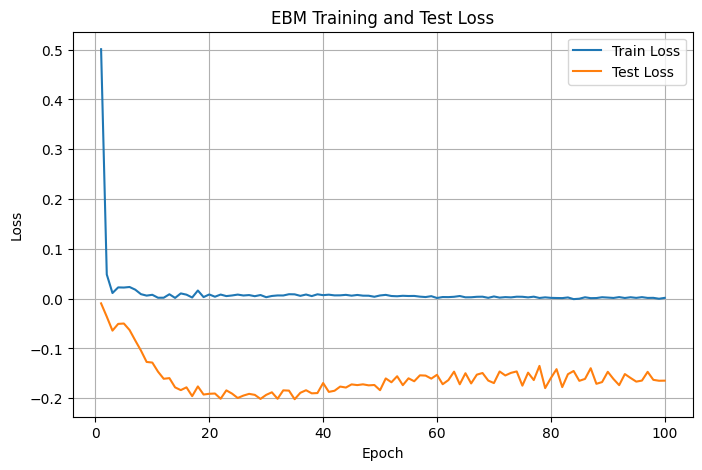

In [49]:
plt.figure(figsize=(8,5))
plt.plot(epoch_history, train_losses, label="Train Loss")
plt.plot(epoch_history, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("EBM Training and Test Loss")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
ebm.eval()
batch_size = 64
image_size = 784
x_init = torch.rand(batch_size, image_size, device=device)

ebm_samples = sgld_sample(ebm, x_init, steps=60, step_size=10.0, noise_scale=0.005)

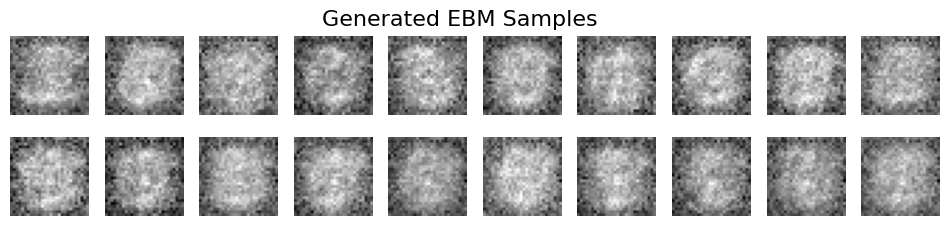

In [51]:
plot_samples(ebm_samples.detach().cpu().numpy(), title="Generated EBM Samples")

In [52]:
def generate_ebm_samples(ebm, n):
  ebm.eval()
  image_size = 784
  x_init = torch.rand(n, image_size, device=device)

  ebm_samples = sgld_sample(ebm, x_init, steps=60, step_size=10.0, noise_scale=0.005)
  #plot_samples(ebm_samples.detach().cpu().numpy(), title="Generated EBM Samples (1000 samples)")
  return ebm_samples

# Part 3: Generation & Verification

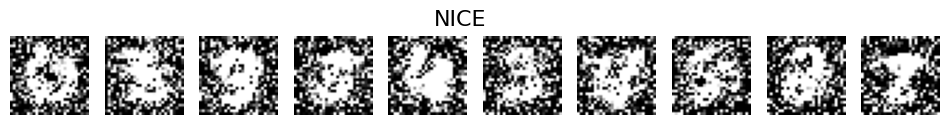

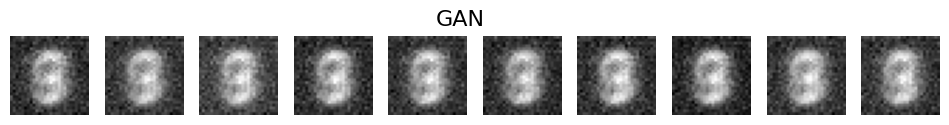

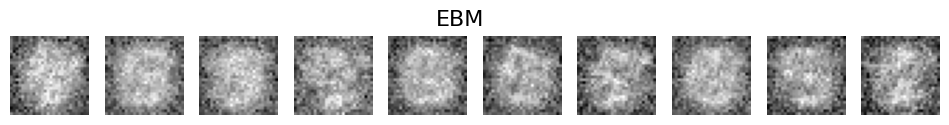

In [155]:

nice_samples = nice_monitored.sample(1000)
gan_samples = generate_gan_samples(generator, n_samples = 1000)
ebm_samples = generate_ebm_samples(ebm, n=1000)


n_display = 10
nice_indices = np.random.choice(len(nice_samples), n_display, replace=False)
gan_indices = np.random.choice(len(gan_samples), n_display, replace=False)
ebm_indices = np.random.choice(len(ebm_samples), n_display, replace=False)

# Select 10 random samples
nice_10 = nice_samples[nice_indices]
gan_10 = gan_samples[gan_indices]
ebm_10 = ebm_samples[ebm_indices]

if torch.is_tensor(nice_10):
    nice_10 = nice_10.detach().cpu().numpy()
if torch.is_tensor(gan_10):
    gan_10 = gan_10.detach().cpu().numpy()
if torch.is_tensor(ebm_10):
    ebm_10 = ebm_10.detach().cpu().numpy()

plot_samples(nice_10, "NICE")
plot_samples(gan_10, "GAN")
plot_samples(ebm_10, "EBM")


Digits in NICE and EBM generated samples, are not recognizable.
In GAN generated smaples, digit 3 and 8 are recognizable. In GAN smaples are similar because of the mode collapse problem which is an inherited problem of GANs.

GAN results are blury. However, NICE results are not recognizable but they are sharp.

NICE samples are also noisy, some digits as 9 and 4 and 3 are recognizable.

EBM samples are very noisy. They just learned the center of pictures. I think if we train EBM more epochs we could have generate better samples but here we have to train models 100 epochs to be able to compare this model's result with previous model's performance.

Comparing with NADE and VAE:

* VAE and NADE were much more recognizable than these new models.
* VAE samples were blury like GANs samples.
* NADE had some pixel noises. But digist were visible but here in NICE due to noises its hard to recognize digits.

* GMM samples are so similar to GANs because, both of these models prefere to generate 3 and 8 digits.
This similarity arises from the way each model captures data distributions. A GMM assumes data can be represented by a limited number of Gaussian components, and digits such as 3 and 8—with their rounded and symmetric shapes—fit well within Gaussian clusters, making them more likely to be generated. In contrast, GANs are prone to mode collapse, where the generator learns to produce only a few outputs that consistently fool the discriminator. Thus, Generator finds digits 3 and 8 as safe digits and prefer to generate them more.


# Part 4: Quantitative Evaluation


## Sample quality metrics:

In [55]:

nice_features = get_features(nice_samples.reshape(-1, 1, 28, 28))
gan_features = get_features(gan_samples)
ebm_features = get_features(ebm_samples.reshape(-1, 1, 28, 28))


fid_nice = calculate_fid(real_features, nice_features)
fid_gan = calculate_fid(real_features, gan_features)
fid_ebm = calculate_fid(real_features, ebm_features)

kid_nice = calculate_kid(real_features, nice_features)
kid_gan = calculate_kid(real_features, gan_features)
kid_ebm = calculate_kid(real_features, ebm_features)

nice_probs = get_labels_and_probs(nice_samples.reshape(-1, 1, 28, 28))
gan_probs = get_labels_and_probs(gan_samples)
ebm_probs = get_labels_and_probs(ebm_samples.reshape(-1, 1, 28, 28))

is_nice, _, _ = calculate_is_and_diversity(nice_probs)
is_gan, _, _ = calculate_is_and_diversity(gan_probs)
is_ebm, _, _ = calculate_is_and_diversity(ebm_probs)

results = {
    "Metric": ["FID (↓)", "KID (x100) (↓)", "Inception Score (↑)"],
    "EBM": [f"{fid_ebm:.2f}", f"{kid_ebm*100:.2f}", f"{is_ebm:.2f}"],
    "NICE": [f"{fid_nice:.2f}", f"{kid_nice*100:.2f}", f"{is_nice:.2f}"],
    "GAN": [f"{fid_gan:.2f}", f"{kid_gan*100:.2f}", f"{is_gan:.2f}"],
}
df_results = pd.DataFrame(results)
print("--- Sample Quality Metrics ---")
print(df_results.to_string(index=False))

--- Sample Quality Metrics ---
             Metric       EBM      NICE       GAN
            FID (↓)    526.31    579.18    996.48
     KID (x100) (↓) 610860.50 364312.12 425708.16
Inception Score (↑)      1.27      2.09      1.02


/tmp/ipython-input-4050176068.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data).to(device))
/tmp/ipython-input-4050176068.py:24: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = sqrtm(sigma1.dot(sigma2))
/tmp/ipython-input-4050176068.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data).to(device))


## Table of metrics for 5 models

| Model | IS | FID    | KID    |
|-------|--------------------|--------|--------|
| VAE   |4.55|259.18|245164.70|
| NADE  |6.33|60.95|39554.59|
| NICE  |2.09|443.54|364312.12|
| GAN   |1.02|996.48|425708.16|
| EBM   |1.27|526.31|610860.50|

As we can see in the table, NADE is the best model.

But among the three new models NICE performed better than the EBM and GAN. It is also visible in generated samples, in NICE samples digits are a little bit more recognizable.

## Computation Trade-oﬀs

In [57]:
def time_sampling(model_name, gen_func, n_single=1, n_batch=100):
    start_time = time.time()
    gen_func(n_single)
    end_time = time.time()
    single_time = end_time - start_time

    start_time = time.time()
    gen_func(n_batch)
    end_time = time.time()
    batch_time = end_time - start_time

    return single_time, batch_time

def nice_gen(n):
    nice_monitored.sample(n)

def gan_gen(n):
    generate_gan_samples(generator, n_samples=n, z_dim=100)

def ebm_gen(n):
    generate_ebm_samples(ebm, n=n)

nice_single, nice_batch = time_sampling("NICE", nice_gen)
gan_single, gan_batch = time_sampling("GAN", gan_gen)
ebm_single, ebm_batch = time_sampling("EBM", ebm_gen)


In [58]:
speed_results = {
    "Model": ["NICE", "GAN", "EBM"],
    "Time for 1 Sample (s)": [f"{nice_single:.4f}", f"{gan_single:.4f}", f"{ebm_single:.4f}"],
    "Time for 100 Samples (s)": [f"{nice_batch:.4f}", f"{gan_batch:.4f}", f"{ebm_batch:.4f}"],
}
df_speed = pd.DataFrame(speed_results)
print("--- Sampling Speed ---")
print(df_speed.to_string(index=False))

--- Sampling Speed ---
Model Time for 1 Sample (s) Time for 100 Samples (s)
 NICE                0.0037                   0.1267
  GAN                0.0004                   0.0005
  EBM                0.0541                   0.0610


| Model | Training Time (s)| Sampling Time single (s)|Sampling Time batch(s)
|-------|-------------|--------|----------|
| VAE   |20.4|0.0032|0.0004|
| NADE  |539.3|0.1556|0.1758|
| NICE  |50.50|0.0037|0.1267|
| GAN   |18.43|0.0004|0.0005|
| EBM   |71.49|0.0541|0.0610|

- NADE is the slowest model during the training process and GAN is the fastest.

- In the sampling process, NADE has the slowest sampling speed becuase of the sequential process during generating cells by chain rule.

- GANs and VAEs are fast in sampling mainly because generating a sample only requires a single forward pass through a neural network .Thus, everything can be done in parallel on a GPU.